# JAK2 activity optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with maximized and minimized pIC50 for JAK2. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learninf for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

In [2]:
sys.path.append('./release/')

In [3]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [4]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

In [5]:
import numpy as np
from tqdm import tqdm, trange
import pickle
import os
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [7]:
from reinforcement import Reinforcement

In [8]:
from rdkit import Chem

In [9]:
from rdkit.Chem import Descriptors

In [7]:
Descriptors.ExactMolWt(Chem.MolFromSmiles('C'))

16.031300127999998

## Setting up the generator

### Loading data for the generator

In [10]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [11]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [12]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens, use_cuda=use_cuda)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [42]:
def plot_hist(prediction, n_to_generate, name, mean=0, std=1, interval=None):
    
    prediction = prediction * std + mean
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel=f'Predicted {name}', 
           title=f'Distribution of predicted {name} for generated molecules')
    if interval:
        ax.axvline(x=interval[0], color='r')
        ax.axvline(x=interval[1], color='r')
    
#     return ax

In [32]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    
    valid_num = (n_to_generate - sanitized.count(''))
    unique_smiles = list(np.unique([s for s in sanitized if s]))[1:]
    unique_num = len(unique_smiles)
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
    dist = plot_hist(prediction, n_to_generate, kwargs['p_name'], kwargs['mean'], kwargs['std'], kwargs['interval'])
        
    return smiles, prediction, valid_num / n_to_generate, unique_num / valid_num

In [17]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [7]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

NameError: name 'gen_data' is not defined

If you want train the model from scratch, uncomment the lines below:

In [11]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [16]:
#losses = my_generator.fit(gen_data, 1500000)

In [17]:
#plt.plot(losses)

In [18]:
#my_generator.evaluate(gen_data)

In [19]:
#my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [20]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Random Forest predictor instead of Recurrent Neural Network, since the availability of the dataset with JAK2 activity data used in the "Deep Reinforcement Learning for de novo Drug Design" paper is restricted under the license agreement. Here instead we use the JAK2 activity data downladed from ChEMBL. The size of this dataset is ~2000 data points, which is not enough to build a reliable deep neural network. Is you want to see a demo with RNN, please checkout logP optimization demo. 

In [19]:
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors

In [20]:
calc = Calculator(descriptors, ignore_3D=True)

In [21]:
pred_data = PredictorData(path='./data/jak2_data.csv', get_features=get_fp)

In [22]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR

In [14]:
model_instance = RFR
model_params = {'n_estimators': 250, 'n_jobs': 10}

In [15]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='regressor')

In [16]:
my_predictor.fit_model(pred_data, cv_split='random')

([0.6483726215705666,
  0.7280142109429215,
  0.67145652063581,
  0.6595633192670245,
  0.652443662403232],
 'R^2 score')

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Maximizing pIC50 for JAK2

Making a copy of the generator that will be optimized

In [23]:
import copy

hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

model_path = './checkpoints/generator/checkpoint_biggest_rnn'

my_generator_max = StackAugmentedRNN(input_size=len(tokens), 
                                     hidden_size=hidden_size,
                                     output_size=len(tokens), 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

# my_generator_unbiased = copy.deepcopy(my_generator_max)

In [39]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

In [41]:
def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(prop[0]/3)

The reward function we will use here is 
$$
R(s) = \exp(\dfrac{predictor(s)}{3}) 
$$

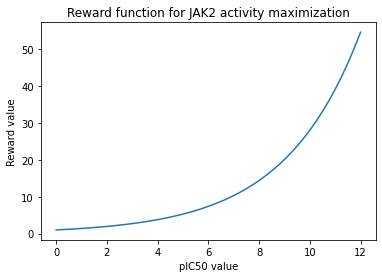

In [27]:
x = np.linspace(0, 12)
y = np.exp(x/3)
plt.plot(x, y)
plt.xlabel('pIC50 value')
plt.ylabel('Reward value')
plt.title('Reward function for JAK2 activity maximization')
plt.show()

In [42]:
RL_max = Reinforcement(my_generator_max, my_predictor, get_reward_max)

In [43]:
rewards_max = []
rl_losses_max = []

In [45]:
import time
import datetime
import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")



for i in range(n_iterations):
    clear_output(wait=True)
    s = time.time()
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss, _  = RL_max.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))
    
    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
  
        
    smiles_cur, prediction_cur = estimate_and_update(RL_max.generator, 
                                                         my_predictor, 
                                                         n_to_generate,
                                                         get_features=get_fp)
        
        
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)
    e = time.time() - s
    
    print(f'Time per iteration {i} {datetime.timedelta(e)}')
    
    
    
    

Policy gradient...:   7%|▋         | 1/15 [00:42<09:54, 42.47s/it]


KeyboardInterrupt: 

In [ ]:
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_max.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

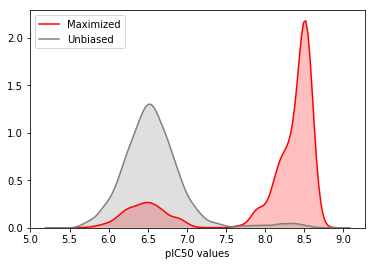

In [50]:
sns.kdeplot(prediction_biased_max,label='Maximized', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('pIC50 values')
plt.show()

# Melting point optimization

In [33]:
import pandas as pd

In [35]:
mp_df = pd.read_excel('data/BradleyMeltingPointDataset.xlsx')
mp_df.head()

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN


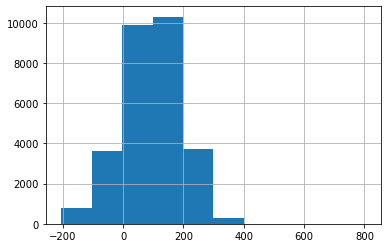

In [36]:
mp_df['mpC'].hist(b)

In [41]:
mp_df = mp_df.drop(mp_df[mp_df['donotuse'] == 'x'].index)

In [68]:
len(mp_df[mp_df['mpC']>400])

0

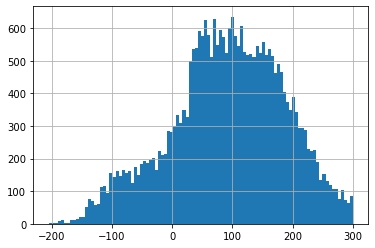

In [75]:
mp_df = mp_df.drop(mp_df[mp_df['mpC']>300].index)
mp_df['mpC'].hist(bins=100)

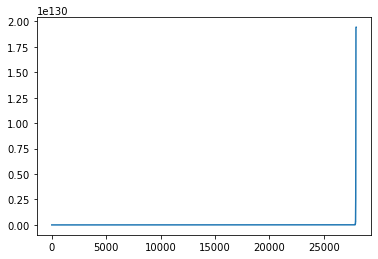

In [72]:
mp_df.sort_values('mpC').reset_index(drop=True)['mpC'].apply(lambda x: np.exp(x)).plot()

In [82]:
mp_df['mpC'].mean(), mp_df['mpC'].std()

(92.0924114641032, 93.92472573003356)

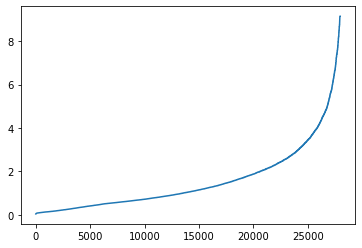

In [77]:
mp_df['mpC_norm'] = ((mp_df['mpC'] - mp_df['mpC'].mean())/mp_df['mpC'].std()).round(4)
mp_df.sort_values('mpC_norm').reset_index(drop=True)['mpC_norm'].apply(lambda x: np.exp(x)).plot()

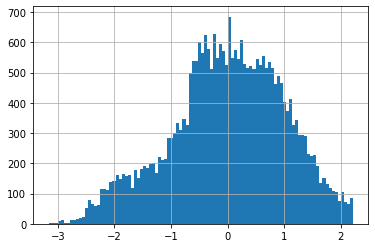

In [78]:
mp_df['mpC_norm'].hist(bins=100)

In [79]:
mp_df[['smiles', 'mpC_norm']].to_csv('data/mpC_data.csv',  index=False)

In [111]:
ic50_df = pd.read_csv('data/jak2_data.csv')
ic50_df['pIC50'].mean(), ic50_df['pIC50'].std()

(7.391543694400837, 1.1809048234923047)

In [114]:
log5_df = pd.read_csv('data/logP_labels.csv')
log5_df['Kow'].mean(), log5_df['Kow'].std()

(2.0677188087848, 1.8288401406888959)

# Multi reward optimization

In [24]:
class PropertyPredictor():
    def __init__(self, rdkit_desc):
        self.desc = rdkit_desc
    def predict(self, smiles, **kwargs):
        valid_smiles = []
        props = []
        nan_smiles = []
        for sm in smiles:
            m = Chem.MolFromSmiles(sm)
            if not m:
                nan_smiles.append(sm)
                continue
            valid_smiles.append(sm)
            props.append(self.desc(m))
        props = np.array(props)
       
        return valid_smiles, props, nan_smiles
            
        

In [25]:
 def get_multi_reward_ranges_max_ic50(smiles, predictors, invalid_reward=0.0, get_features=get_fp):
    rwds = []
    stats = [[6.571506827780664,  0.405556162912055]] #ic50
    for i, p in enumerate(predictors):
        mol, prop, nan_smiles = p.predict([smiles], get_features=get_features)
        
        if len(nan_smiles) == 1:
            return invalid_reward, [invalid_reward] * len(predictors)
        
        if i == 0: #ic50
            rwds.append(np.exp((prop[0] - stats[i][0]) / stats[i][1])/3)
        elif i == 1: #logp
            rwds.append(2. if ((prop[0] > 1.) and (prop[0] < 4.)) else 0.)
        elif i == 2: #mpt
            p = (prop[0] * 93.92472573003356) + 92.0924114641032
            rwds.append(2. if ((p >= 50.) and (p <= 250.0)) else 0.)
        else: #mw
            rwds.append(2. if ((prop[0] > 180.) and (prop[0] < 450.)) else 0.)
    return np.sum(rwds), rwds 

In [42]:
def get_multi_reward_with_mpt(smiles, predictors, invalid_reward=0.0, get_features=get_fp):
    rwds = []
#     stats = [[7.391543694400837, 1.1809048234923047], [2.0677188087848, 1.8288401406888959], [0,1]]
    stats = [[6.571506827780664,  0.405556162912055], [2.3744083807347933,  0.9429912852261682], [153.76311716715495,  33.472182703355514]]

    for i, p in enumerate(predictors):
        mol, prop, nan_smiles = p.predict([smiles], get_features=get_features)
        
        if len(nan_smiles) == 1:
            return invalid_reward, [invalid_reward] * len(predictors)
        if i == 2: #mpt
            p = (prop[0] * 93.92472573003356) + 92.0924114641032
            rwds.append(np.exp((p - stats[i][0]) / stats[i][1]))
        elif i == 0: #ic50
            rwds.append(np.exp(-(prop[0] - stats[i][0]) / stats[i][1]))
        else:
            rwds.append(np.exp((prop[0] - stats[i][0]) / stats[i][1]))
    return np.sum(rwds), rwds
    

In [41]:
def get_multi_reward_with_mw(smiles, predictors, invalid_reward=0.0, get_features=get_fp):
    rwds = []
#     stats = [[7.391543694400837, 1.1809048234923047], [2.0677188087848, 1.8288401406888959], [0,1]]
    stats = [[6.571506827780664,  0.405556162912055], [2.3744083807347933,  0.9429912852261682]]

    for i, p in enumerate(predictors):
        mol, prop, nan_smiles = p.predict([smiles], get_features=get_features)
        
        if len(nan_smiles) == 1:
            return invalid_reward, [invalid_reward] * len(predictors)
        if i == 2: #mw
            rwds.append(2. if (prop[0] > 180. and prop[0] < 450.) else 0.)
        elif i == 0: #ic50
            rwds.append(np.exp(-(prop[0] - stats[i][0]) / stats[i][1]))
        else:
            rwds.append(np.exp((prop[0] - stats[i][0]) / stats[i][1]))
    return np.sum(rwds), rwds

In [47]:
def get_multi_reward(smiles, predictors, invalid_reward=0.0, get_features=get_fp):
    rwds = []
    stats = [[6.571506827780664,  0.405556162912055], [2.3744083807347933,  0.9429912852261682], [153.76311716715495,  33.472182703355514]]
#     stats = [[0,1]]
    for i, p in enumerate(predictors):
        print(smiles)
        mol, prop, nan_smiles = p.predict([smiles], get_features=get_features)
        
        if len(nan_smiles) == 1:
            return invalid_reward, [invalid_reward] * len(predictors)
        rwds.append(np.exp((prop[0] - stats[i][0]) / stats[i][1]))
    return np.sum(rwds), rwds
    

In [24]:
def get_range_reward(smiles, predictors, invalid_reward=0.0, get_features=get_fp):
    rwds = []
    for i, p in enumerate(predictors):
       
        mol, prop, nan_smiles = p.predict([smiles], get_features=get_features)
        
        if len(nan_smiles) == 1:
            return invalid_reward, [invalid_reward] * len(predictors)
        rwds.append(2. if (prop[0] > 180. and prop[0] < 450.) else 0.)
    return np.sum(rwds), rwds

In [26]:
predictors = []
predictors_names = ['IC50', 'logP', 'mpC']
stats_to_norm = [[6.571506827780664,  0.405556162912055], [2.3744083807347933,  0.9429912852261682],[153.76311716715495,  33.472182703355514]]
stats_to_real = [[0,1], [0,1], [92.0924114641032, 93.92472573003356]]

for i, d in enumerate([{'model_type': 'regressor', 'data_path': './data/jak2_data.csv', 'n_estimators': 250, 'n_jobs': 10}, 
                       {'model_type': 'regressor', 'data_path': './data/logP_labels.csv', 'n_estimators': 250, 'n_jobs': 10,},
                      {'model_type': 'regressor', 'data_path': './data/mpC_data.csv', 'n_estimators': 250, 'n_jobs': 10,}
                      ]):
    model_type = d['model_type']
    p_name = d['data_path'].split('/')[-1].split('_')[0]
   
    data = PredictorData(path=d['data_path'], get_features=get_fp)
    
    del d['model_type']
    del d['data_path']
    model_instance = RFR
    my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=d,
                           model_type=model_type)
    
    if os.path.exists(f'checkpoints/predictors/predictor_{p_name}0.pkl'):
        print(f'Loading predictor {i}')
        my_predictor.load_model(f'checkpoints/predictors/predictor_{p_name}')
    else:
        print(f'Fitting predictor {i}')
        print(my_predictor.fit_model(data, cv_split='random'))

        my_predictor.save_model(f'checkpoints/predictors/predictor_{p_name}')
    
    predictors.append(my_predictor)

Loading predictor 0
Loading predictor 1
Loading predictor 2


In [27]:
predictors = [PropertyPredictor(Descriptors.ExactMolWt)]
predictors_names = ['mwt']

In [27]:
predictors.append(PropertyPredictor(Descriptors.ExactMolWt))
predictors_names.append('mwt')
stats_to_norm.append([367.93905744040325, 107.99177665887633])
stats_to_real.append([0,1])

In [46]:
np.exp(10)

22026.465794806718

Generating molecules...:   0%|          | 0/50 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


Mean value of predictions: 6.5642750185628875
Proportion of valid SMILES: 0.58


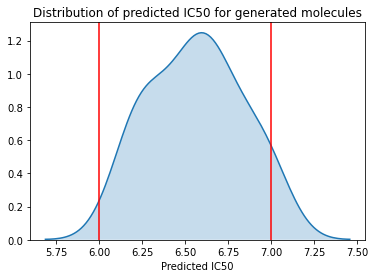

Generating molecules...:   0%|          | 0/50 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 50/50 [00:02<00:00, 21.34it/s]


Mean value of predictions: 2.1559488394826554
Proportion of valid SMILES: 0.52


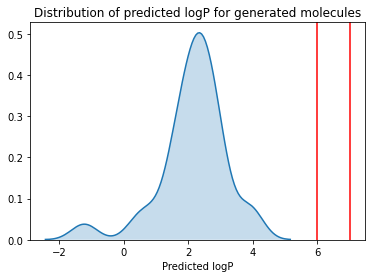

Generating molecules...:   0%|          | 0/50 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 50/50 [00:02<00:00, 21.00it/s]


Mean value of predictions: 150.89645355884423
Proportion of valid SMILES: 0.58


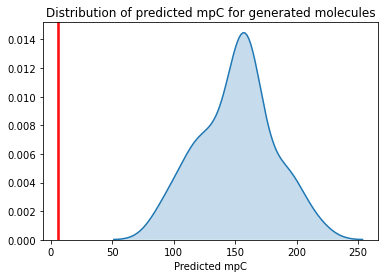

Generating molecules...:   0%|          | 0/50 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...:  18%|█▊        | 9/50 [00:00<00:02, 20.30it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [43]:
unbiased_predictions = []
for p_name, p, s in zip(predictors_names, predictors, stats_to_real):
    smiles, prediction_unbiased, _, _ = estimate_and_update(my_generator_max,
                                                           p,
                                                           n_to_generate=50, 
                                                 get_features=get_fp,
                                                         p_name=p_name,
                                                         mean=s[0], 
                                                 std=s[1],
                                                interval=[6,7]
                                                    )
    
    plt.show()
    plt.clf()
    prediction_unbiased = (prediction_unbiased * s[1]) + s[0]
    unbiased_predictions.append(prediction_unbiased)
   

In [75]:
#mol weight
unbiased_predictions[0].mean(), unbiased_predictions[0].std()

(367.93905744040325, 107.99177665887633)

In [79]:
#ic50, logp, mt
for p in unbiased_predictions:
    print(p.mean(), end=',  ')
    print(p.std())

6.571506827780664,  0.405556162912055
2.3744083807347933,  0.9429912852261682
153.76311716715495,  33.472182703355514


In [49]:
RL_multi = Reinforcement(my_generator_max, predictors, get_multi_reward_ranges_max_ic50)

In [50]:
n_to_generate = 200
n_policy_replay = 10
n_policy = 1
n_iterations = 1000
n_to_draw = 20
exp_name = 'test_logging'

In [ ]:
import time
import datetime
import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


rewards_max = []
rl_losses_max = []
distinct_rewards = []
num_valid_smiles = []


if not os.path.exists(f'experiments/{exp_name}'):
    os.mkdir(f'experiments/{exp_name}')

for i in range(n_iterations):
    clear_output(wait=True)
    s = time.time()
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss, cur_distinct_rewards = RL_multi.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))
        distinct_rewards.append(cur_distinct_rewards)
        
        
    
    print(rewards_max)
    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.savefig(f'experiments/{exp_name}/{exp_name}_avg_reward.png')
    plt.show()
    
    plt.plot(rl_losses_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
    

    
    for p in range(len(distinct_rewards[0])):
        print(moving_average(np.array(distinct_rewards)[:, p], n=min(10, len(distinct_rewards))))
        plt.plot(moving_average(np.array(distinct_rewards)[:, p], n=min(10, len(distinct_rewards))))
    
    plt.xlabel('Training iteration')
    plt.ylabel('Distinct rewards')
    plt.legend(labels=predictors_names)

    plt.savefig(f'experiments/{exp_name}/{exp_name}_distinct_rewards.png')
    plt.show()
    

        
    for p_name, p, unbiased_preds in zip(predictors_names, predictors, unbiased_predictions):
        if p_name == 'mpC':
            mean = 92.0924114641032
            std =  93.92472573003356
        else:
            mean = 0
            std  = 1
        
        plot_hist(unbiased_preds, 200, p_name)
        smiles_cur, prediction_cur = estimate_and_update(RL_multi.generator, 
                                                         p, 
                                                         n_to_generate,
                                                         get_features=get_fp,
                                                         p_name=p_name,
                                                        mean=mean,
                                                         std=std
                                                        )
        plt.savefig(f'experiments/{exp_name}/{exp_name}_property_dist_{p_name}.png')
        plt.show()
        
    num_valid_smiles.append(len(smiles_cur)/n_to_generate)
    
    with open(f'experiments/{exp_name}/{exp_name}_generated_smiles.txt', 'a') as f:
        for sm in smiles_cur:
            f.write(str(Chem.MolToSmiles(sm)))
            f.write('\n')
        f.write('\n')
    
    plt.plot(num_valid_smiles)
    plt.xlabel('Training iteration')
    plt.ylabel('Proportion of valid smiles')
    plt.savefig(f'experiments/{exp_name}/{exp_name}_num_valid_smiles.png')
    plt.show()

#     print('Sample trajectories:')
#     for sm in smiles_cur[:5]:
#         print(sm)
    e = time.time() - s
    
    print(f'Time per iteration {i} {datetime.timedelta(e)}')
    RL_multi.generator.save_model(f'experiments/{exp_name}/{exp_name}_generator.pth')

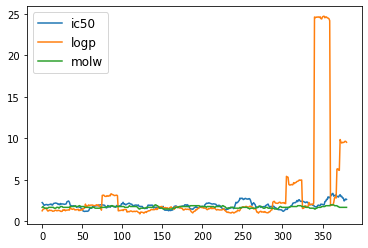

In [73]:
plt.plot(moving_average(np.array(distinct_rewards)[:400, 0], n=min(20, len(distinct_rewards))))
plt.plot(moving_average(np.array(distinct_rewards)[:400, 1], n=min(20, len(distinct_rewards))))
plt.plot(moving_average(np.array(distinct_rewards)[:400, 2], n=min(20, len(distinct_rewards))))

plt.legend(labels=['ic50', 'logp', 'molw'], fontsize=12)
plt.savefig(f'experiments/{exp_name}/{exp_name}_distinct_rewards_beginning_of_training.png')


In [70]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 30.88it/s]


Mean value of predictions: 8.335710212602008
Proportion of valid SMILES: 0.415


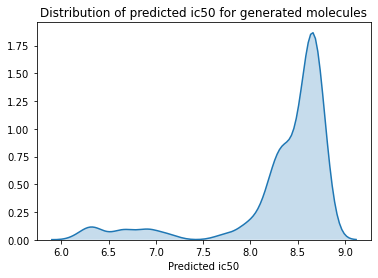

In [74]:
smiles_cur, prediction_cur = estimate_and_update(RL_multi.generator, 
                                                         predictors[0], 
                                                         200,
                                                         get_features=get_fp,
                                                         p_name='ic50',
                                                        mean=0,
                                                         std=1
                                                        )

generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_cur]
# sanitized_gen_mols_max = [generated_mols_max[i] 
#                           for i in np.where(np.array(generated_mols_max) != None)[0]]
n_to_draw = 20
ind = np.random.randint(0, len(smiles_cur), n_to_draw)
mols_to_draw_max = [generated_mols_max[i] for i in ind]
legends = ['pIC50 = ' + str(prediction_cur[i]) for i in ind]

In [95]:
img  =Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

In [108]:
img.getbands()

('R', 'G', 'B')

In [106]:
ar = np.array(img.convert('RGB').getdata()).reshape((1200,1500,3))
ar.shape

(1200, 1500, 3)

In [98]:
ar.min()

0

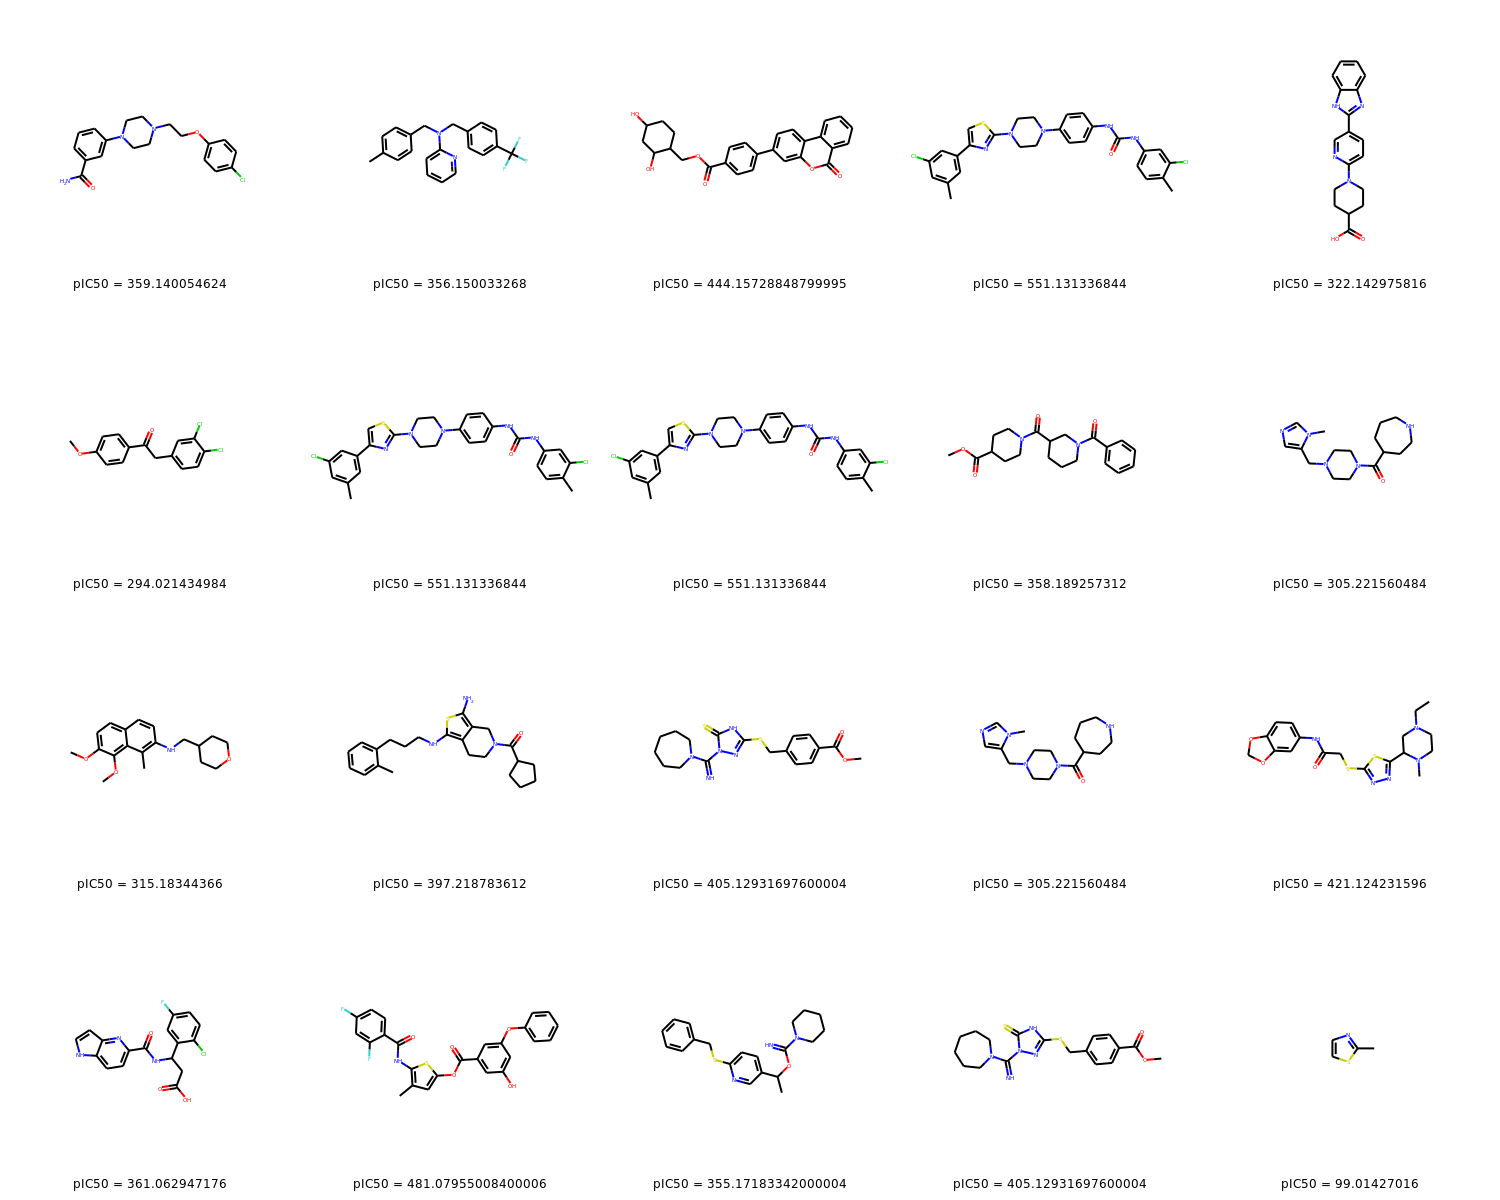

In [113]:
from PIL import Image
img_2 = Image.fromarray(matplotlib.image.pil_to_array(img), 'RGB')
img_2

In [66]:
img.save('img.png')

## Testing tensorboard logging

In [1]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def generate(RL_multi.generator, n_to_generate):
    

In [9]:
import time
import datetime
import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")




if not os.path.exists(f'experiments/{exp_name}'):
    os.mkdir(f'experiments/{exp_name}')

writer = SummaryWriter(f'experiments/{exp_name}')

for step in range(n_iterations):
    
   
    start = time.time()
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss, cur_distinct_rewards = RL_multi.policy_gradient(gen_data, get_features=get_fp)
    
    
    
    for i, p_name in enumerate(predictors_names):
        writer.add_scalar(f'distinct_rewards/{p_name}',  cur_distinct_rewards[i], step)
    writer.add_scalar('final_reward', cur_reward, step)

   
    for p_name, p, s, unbiased_preds in zip(predictors_names, predictors, stats_to_real, unbiased_predictions):
      
        plot_hist(unbiased_preds, 200, p_name)
        
        smiles_cur, prediction_cur, valid_ratio, unique_ratio = estimate_and_update(RL_multi.generator, 
                                                         p, 
                                                         n_to_generate,
                                                         get_features=get_fp,
                                                         p_name=p_name,
                                                        mean=s[0],
                                                         std=s[1]
                                                        )
        
        
        plt.savefig(f'experiments/{exp_name}/{exp_name}_property_dist_{p_name}.png')
        plt.show()
        
        if step % 100 == 0:
            writer.add_histogram(f'{p_name}_distribution', prediction_cur * s[1] + s[0], step)
        
    writer.add_scalar('valid_smiles_ratio', valid_ratio, step)
    writer.add_scalar('unique_smiles_ratio', unique_ratio, step)
       
  
    
    if step % 1 == 0:
        with open(f'experiments/{exp_name}/{exp_name}_generated_smiles.txt', 'a') as f:
            for sm in smiles_cur:
                f.write(str(sm))
                f.write('\n')
            f.write('\n')
        
        ind = np.random.randint(0, len(smiles_cur), n_to_draw)
        mols_to_draw_max = [Chem.MolFromSmiles(smiles_cur[i], sanitize=True) for i in ind]
        legends = ['pIC50 = ' + str(prediction_cur[i]) for i in ind]
       
        
        img  = Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

        writer.add_image('Generated SMILES', matplotlib.image.pil_to_array(img), step, dataformats='HWC')
    

    e = time.time() - start
    clear_output(wait=True)
    print(f'Time per iteration {step}: {datetime.timedelta(seconds=e)}')
    RL_multi.generator.save_model(f'experiments/{exp_name}/{exp_name}_generator.pth')

writer.close()

NameError: name 'exp_name' is not defined

In [8]:
import datetime
print(datetime.timedelta(microseconds=58769563))

0:00:58.769563


### Minimizing pIC50 for JAK2

Next we will minimize the pIC50 fpr JAK2.

The reward function we will use here is 
$$
R(s) = \exp(\dfrac{-predictor(s)}{3} + 3) 
$$

In [ ]:
def get_reward_min(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(-prop[0] + 1)

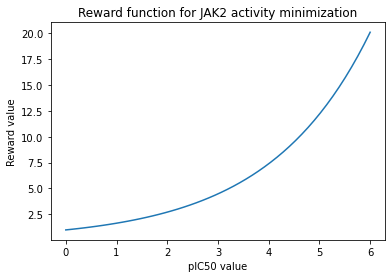

In [64]:
x = np.linspace(0, 6)
y = np.exp(x/2)
plt.plot(x, y)
plt.xlabel('pIC50 value')
plt.ylabel('Reward value')
plt.title('Reward function for JAK2 activity minimization')
plt.show()

Making a copy of the generator that will be optimized

In [42]:
my_generator_min = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)
my_generator_min.load_model(model_path)

In [43]:
RL_min = Reinforcement(my_generator_min, my_predictor, get_reward_min)

In [44]:
rewards_min = []
rl_losses_min = []

Policy gradient...: 100%|██████████| 15/15 [02:16<00:00,  9.08s/it]


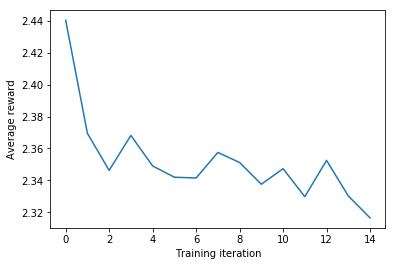

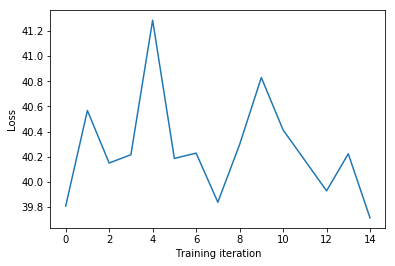

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 19.77it/s]


Mean value of predictions: 6.563484602497407
Proportion of valid SMILES: 0.675


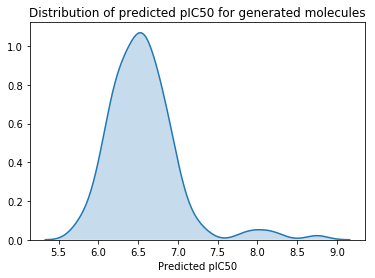

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(C)C(CCCCCCCC(CCC(C)(C)C)CCS(=O)(=O)c1cccc(C)c1)OC(=O)CC
C=C(CCC=C1C(=O)Oc1C)C1CCC2(CCN(CCCCO)CC2)OC1=O
C=C(Nc1ccc2[nH]c(-c3ccccc3)nc2c1)C1CCC(C)CC1
C=CCc1ccc(C2=C(N(CCC)C3CCCCC3)C(=O)NC(=O)N2)cc1
C=CCn1C2=NOC(=O)c3c4c(c(Cl)cc2OCN(C)C)c(C(F)(F)F)cn(c2ccccc2)c3=C1C4=O


Policy gradient...: 100%|██████████| 15/15 [02:14<00:00,  9.00s/it]


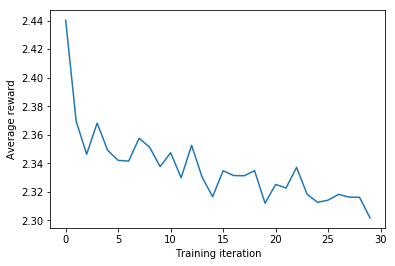

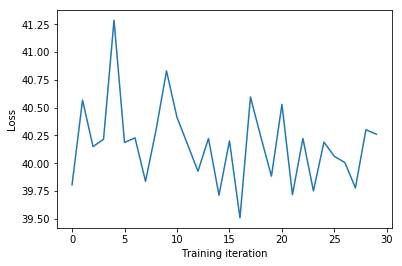

Generating molecules...: 100%|██████████| 200/200 [00:10<00:00, 20.01it/s]


Mean value of predictions: 6.608022657138947
Proportion of valid SMILES: 0.69


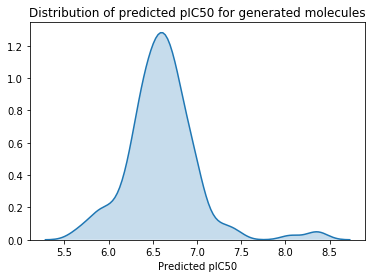

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1CNC(=O)C(C#N)=C1c1ccc(OC)cc1
C=CCN1CCC2(CCC(C)CCCC=C(C)CCc3ccccc3CSCC2=O)C1
CC(=CC1CCC2CC3C4C(=O)C=CCC(C)C4=CC=CC3(C)CCC12)c1ccccc1
CC(=NNCCn1ccnc1)c1ccccc1Cl
CC(=O)NC1Cc2ccccc2C1


Policy gradient...: 100%|██████████| 15/15 [02:12<00:00,  8.62s/it]


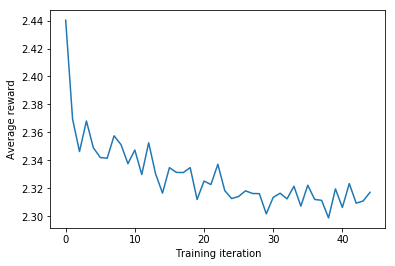

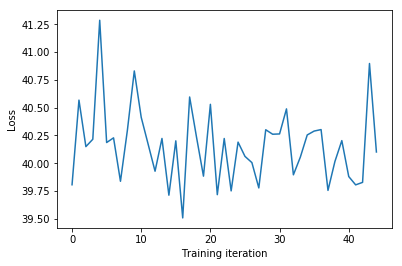

Generating molecules...: 100%|██████████| 200/200 [00:10<00:00, 19.39it/s]


Mean value of predictions: 6.5738642131756295
Proportion of valid SMILES: 0.63


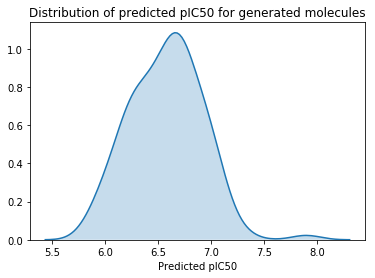

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1c2ccccc2C(=O)N1CCNC(=O)Nc1ccc(C(=O)OCC)cc1
C=CCNC(=O)C(C)OC(=O)c1ccsc1C(=O)C(C)C
C=CS(=O)(=O)Nc1ccc(C(=O)N2CCCC(C(=O)Nc3cccc(OC)c3)C2)cc1
CC(=O)C1CN(S(=O)(=O)c2cn(Cc3ccccc3)c3ccccc23)CCs1N(C)C
CC(=O)N1CCN(C(=O)CN2C(=O)c3ccccc3C2C(=O)c2ccccc2)CC1


Policy gradient...: 100%|██████████| 15/15 [02:13<00:00,  9.06s/it]


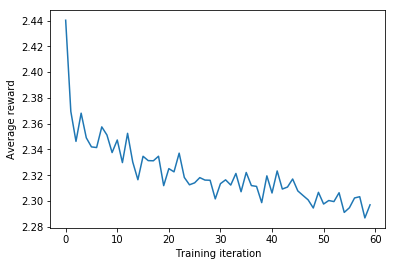

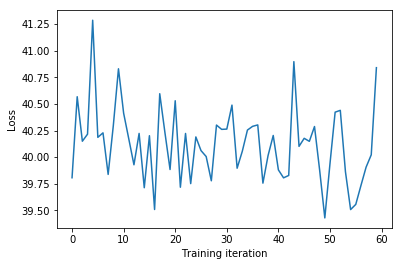

Generating molecules...: 100%|██████████| 200/200 [00:10<00:00, 19.66it/s]


Mean value of predictions: 6.5600334820150605
Proportion of valid SMILES: 0.62


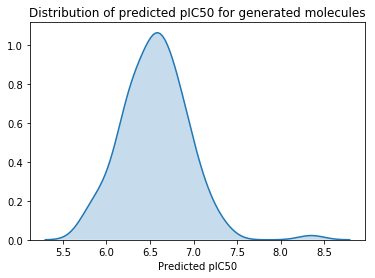

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C1=CN(CCCc2ccccn2)ON=C2CC(c3ccc4c(c3)OCO4)=C12
C=C1C=CN2C(=C(C(=O)OCC)C(N3CCc4ccccc4C3)=NC2(C)C)C1C(O)C(F)(F)F
C=CC(COC(=O)c1ccc(C)c(Cl)c1)=C1CCC(C#N)CN1C
C=CNc1ncnc2c1ncn2CC(c1ccc(OC)cc1)C1CC1
CC(=NN1CCC2(CC1)CC(c1ccc(Cl)c(Cl)c1)CO2)c1n[nH]c2ccc(C(=O)Nc3ccc(Cl)cc3)cc12


Policy gradient...: 100%|██████████| 15/15 [02:12<00:00,  8.71s/it]


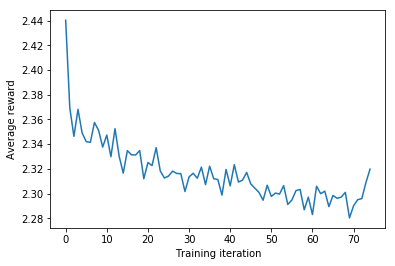

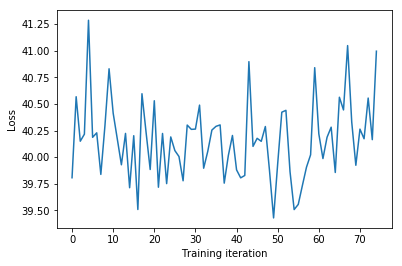

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 17.30it/s]


Mean value of predictions: 6.595570553275734
Proportion of valid SMILES: 0.645


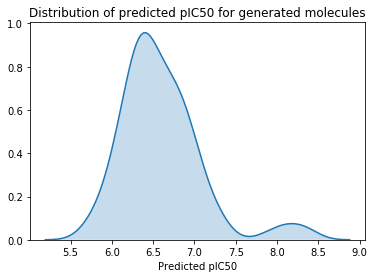

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#Cc1cc(Cl)cn1CN1CCN(CC(C)(C)c2ccccc2)C(OCC(O)CO)C1
C=C1C=C(C)c2cc(S(=O)(=O)NCc3ccccc3)ccc2N1CC
C=C1NC(=O)C(S(=O)(=O)NC)=C(C)NC(=S)OC(OC(C)=O)COC1=O
C=CCN1C(=O)c2cc(c3ccccc3)ccc2Oc1C
CC(=CCC(O)OC1CC2C3CCC4CC(O)CCC4(C)C3CCC12C)CCCC(C)C


Policy gradient...: 100%|██████████| 15/15 [02:12<00:00,  8.82s/it]


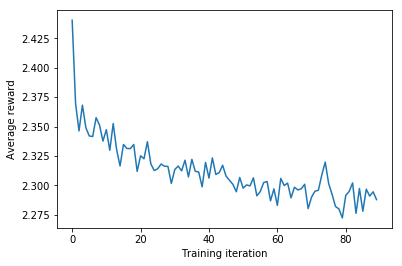

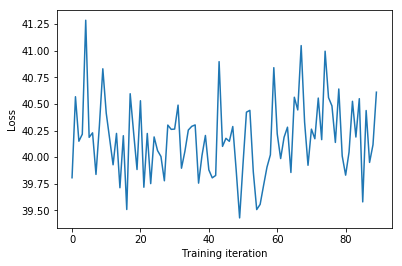

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 20.18it/s]


Mean value of predictions: 6.566664181514168
Proportion of valid SMILES: 0.705


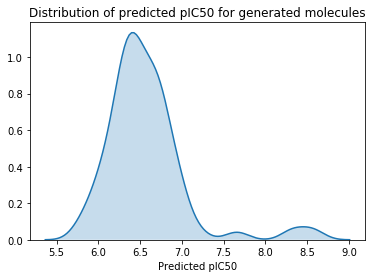

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1C(=O)N(CC)S(=O)(=O)c2ccc(S(=O)(=O)Nc3cccc(Cl)c3)cc21
C=C1OC(C)CC(C)(O)C(C)C=C1C
C=CCN(CC1CCN(C(=O)c2ccc(OCC(C)C)cc2)C1)c1ccc(Cl)cc1F
CC(=O)N1CCN(S(=O)(=O)c2cccc3nn(Cc4ccccc4)nc23)CC1
CC(=O)NC(C1CCCCC1)C(C(=O)O)n1ccnc1


Policy gradient...: 100%|██████████| 15/15 [02:09<00:00,  8.55s/it]


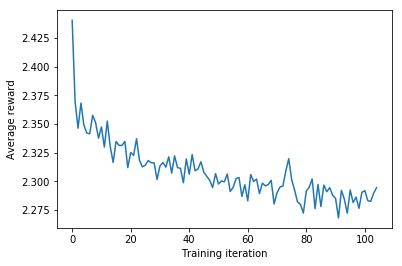

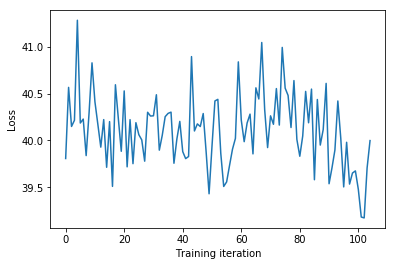

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 21.75it/s]


Mean value of predictions: 6.546275928478287
Proportion of valid SMILES: 0.755


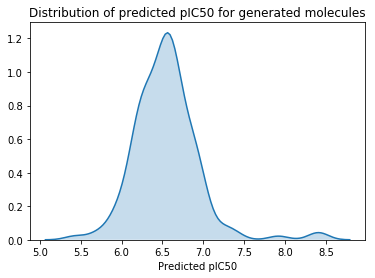

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(c1ccc(OC)cc1)C1(O)OC(CO)C(O)C1=O
C=C1C(OC(C)=O)=C(OCCOOC(C)=O)C(COC(=O)O)OC1c1ccc(OC)c(O)c1
C=CCC(C)c1[nH]c2ccccc2c1C(=O)OCC
C=CCN(C(=O)C(CC(=O)c1ccc2c(c1)OCO2)Cc1ccccc1)c1ccc(C)c(C)c1C(=O)OC
C=CCN1C(=O)CCCC1NC(=O)Nc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [02:11<00:00,  8.63s/it]


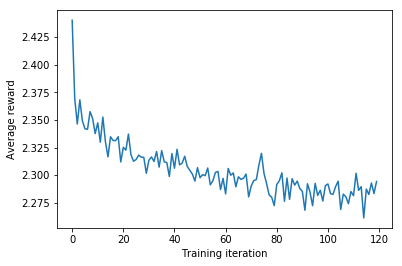

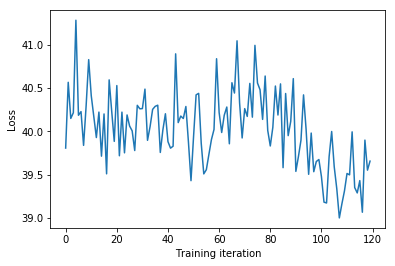

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 21.19it/s]


Mean value of predictions: 6.5856515957605595
Proportion of valid SMILES: 0.7


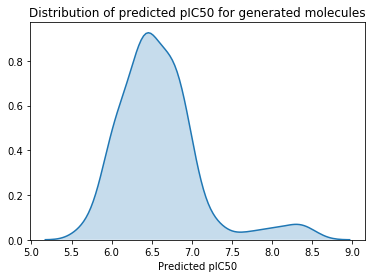

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CC=C1OC(=O)C(O)(CC)CC1C1C(O)CC(C)(C)CCC1OC(=C)C
C=CCNC(=O)c1nc2ccccc2nc1NCCN1CCCC1C
C=Cc1ccc(Oc2ccc(OC)cc2)c(NCCc2ccccc2)n1
CC(=CC(O)C=CCCC=CCC(C)CCCC(C)C)CC(O)C(CC(C)C)C(O)C(C)C
CC(=O)C1CN2C=C(C)C(CC2)N1c1cccnc1


Policy gradient...: 100%|██████████| 15/15 [02:09<00:00,  8.77s/it]


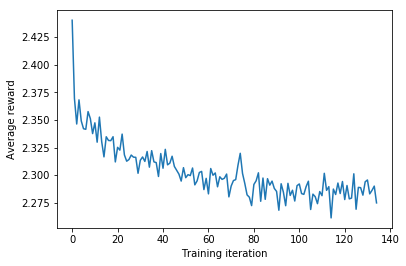

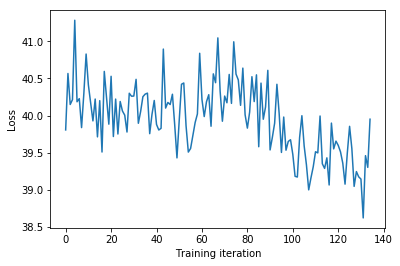

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 21.14it/s]


Mean value of predictions: 6.58699130030844
Proportion of valid SMILES: 0.77


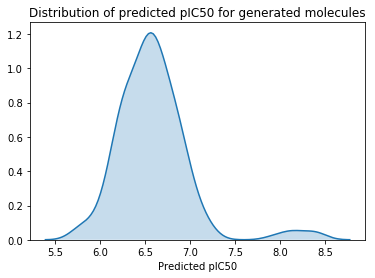

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#CC(O)COc1c(OC)cccc1OC
C#CCCCC(O)(CCCC)C(=O)NC(CC(=O)O)C(=O)N(CCCC(O)(O)CCC)CNC(C)=O
C1CCNCC1
C=C(C)C(CCC=CCC=CCCC(=O)O)(CCC(=O)O)C(C)C(C)CC
C=C1OC(C(=O)N(C)C)C(O)C1O


Policy gradient...: 100%|██████████| 15/15 [02:08<00:00,  8.48s/it]


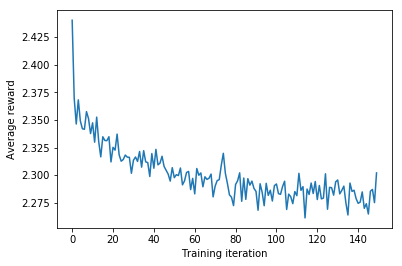

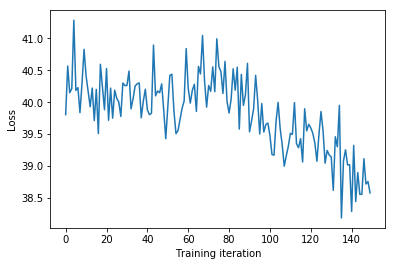

Generating molecules...: 100%|██████████| 200/200 [00:09<00:00, 20.48it/s]


Mean value of predictions: 6.523853819020249
Proportion of valid SMILES: 0.745


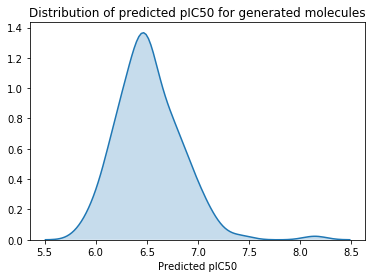

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=NOC(=O)c1cc(N2CCC(C(N)=O)CC2)cs1)OC(=O)Cc1ccccc1
CC(=O)N(Cc1ccccc1)C(c1ccc(C(F)(F)F)cc1F)C(C)C
CC(=O)Oc1ccc(N2CCN(C(=O)C3CCCCC3)CC2)cc1C
CC(=O)c1ccc(-c2ccc(C(=O)N3CCN(c4ccc(C)cc4)CC3)cc2)cc1
CC(C)(C)SC(=S)NCC1CCC(Nc2ncc(C(NS(=O)(=O)c3cccnc3)c3ccccc3)s2)CC1


Policy gradient...: 100%|██████████| 15/15 [02:06<00:00,  8.36s/it]


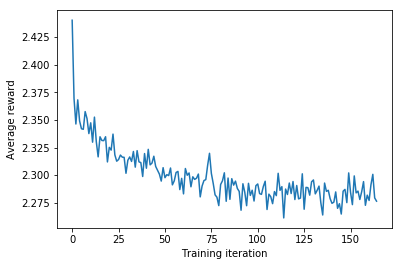

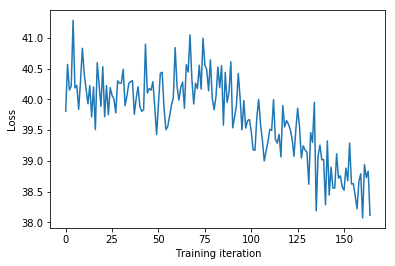

Generating molecules...:  12%|█▏        | 24/200 [00:01<00:07, 22.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



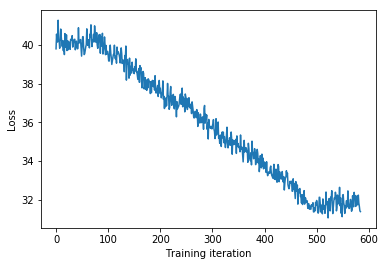

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 25.40it/s]


Mean value of predictions: 6.377415376305133
Proportion of valid SMILES: 0.875


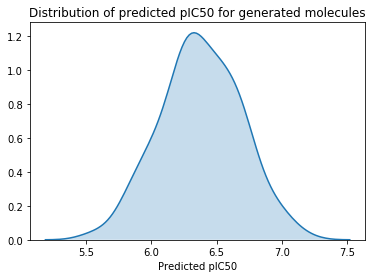

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CC(C)C(=O)OCC=CC1C(=Cc2ccccc2)C=CC1O
C=CCC1N2CCC(C(=O)N1c1ccccc1)C(O)C2
C=CCCCC(CC(N)C(Cc1ccccc1)NC(=O)OCOC(=O)C(=O)O)C(=O)NC(CC(C)C)C(C)C
CC(=Cc1ccccc1C)NC(=O)C(Cc1ccc(OCCn2cccc2)cc1)C(=O)O
CC(=NOCCc1ccccc1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:56<00:00,  7.71s/it]


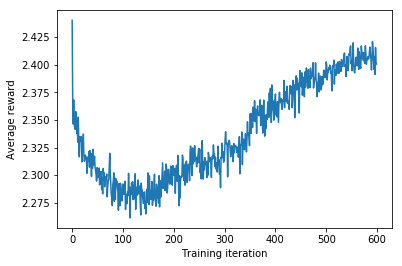

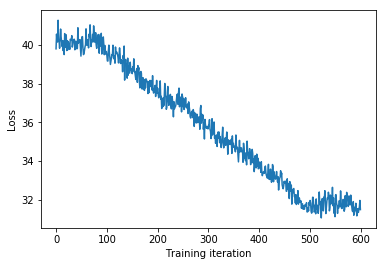

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 26.75it/s]


Mean value of predictions: 6.36577187732326
Proportion of valid SMILES: 0.86


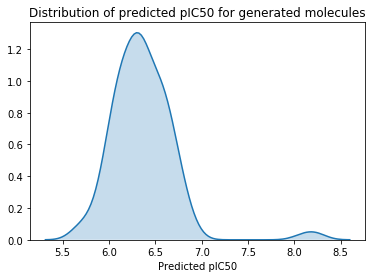

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C
C(Nc1ccccc1)=C1CCCC1
C=C(C)OCCCCCOc1ccc2c(c1)Oc1ccccc1C(COC(=O)CCCCC)=C2
C=CCc1cc(O)c(OCC)c(O)c1
CC(=O)C(Cc1ccccc1)N(C(=O)c1cccc(C)c1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:56<00:00,  7.88s/it]


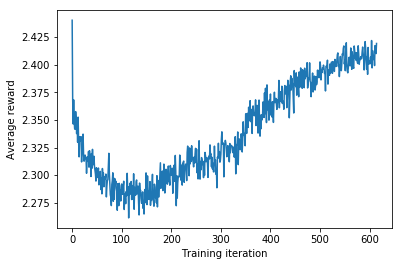

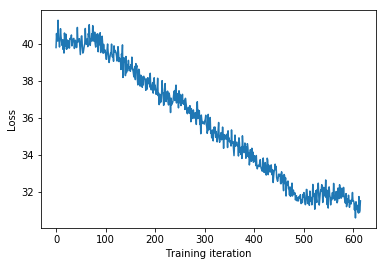

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 27.04it/s]


Mean value of predictions: 6.311057334856158
Proportion of valid SMILES: 0.9


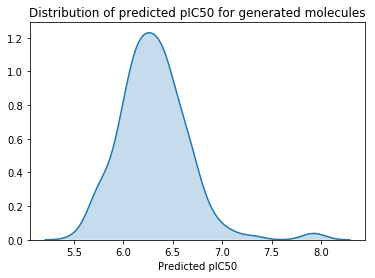

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCCCCNC(=O)C1=CN(C)SC(=C(c2ccccc2)c2ccccc2)C1=O
C=CCNC(Cc1ccccc1)C(=O)NCC(CCCc1ccccc1)CC1CNC(=O)N(c2ccccc2OC)C1
CC(=NNc1ccccc1)c1ccccc1
CC(=O)C1=Cc2cc(Cl)ccc2OC1=O
CC(=O)Nc1cc(CNC2CCCCC2)ccc1Cl


Policy gradient...: 100%|██████████| 15/15 [01:54<00:00,  7.74s/it]


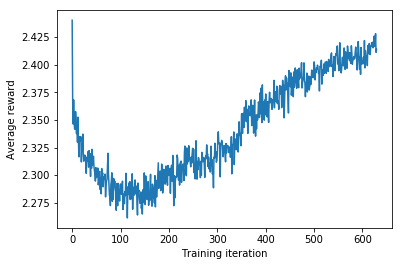

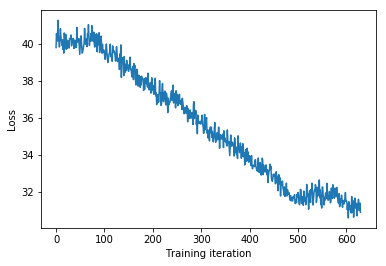

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 26.79it/s]


Mean value of predictions: 6.32933745523319
Proportion of valid SMILES: 0.91


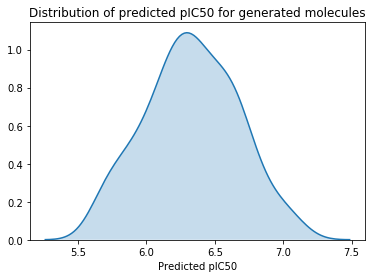

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(Nc1cccs1)c1ccccc1NC(=O)CCCc1ccc(C)cc1
C=CC(OC(=O)CCCCC)c1ccccc1
C=CCNC(C)=O
C=CCn1cc(C(C)C)c2ccccc21
CC(=NO)c1cccc2ccccc12


Policy gradient...: 100%|██████████| 15/15 [01:53<00:00,  7.64s/it]


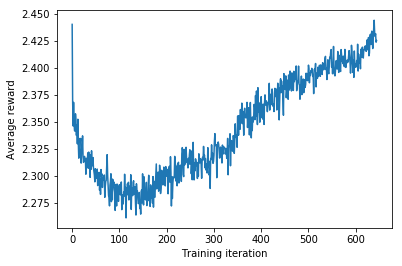

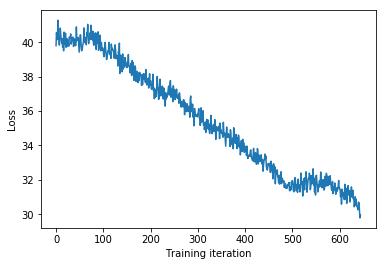

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 31.27it/s]


Mean value of predictions: 6.288977235337378
Proportion of valid SMILES: 0.88


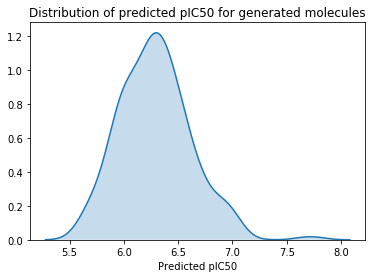

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Brc1ccccc1
C1=C(c2ccccc2)CCN1Cc1ccccc1
C=C1OC2CC(C)C(CCC1C)C(O)(CO)CCC2(C)C
C=CCCN(C(=O)c1ccccc1)c1ccc(N(C)C)cc1
C=CCNC(=O)COc1ccccc1CC


Policy gradient...: 100%|██████████| 15/15 [01:51<00:00,  7.44s/it]


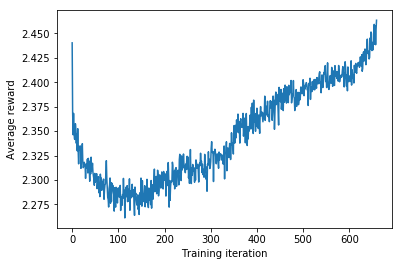

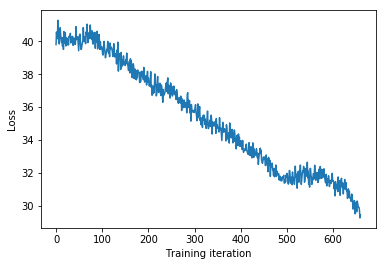

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 29.03it/s]


Mean value of predictions: 6.313581095130128
Proportion of valid SMILES: 0.845


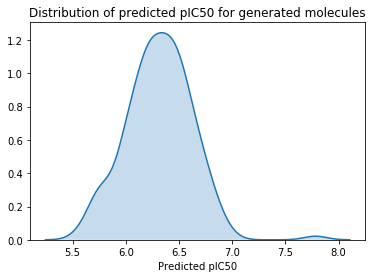

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=O)N(CCO)CCNCCCN
CC(=O)N1CCCc2ccccc21
CC(=O)NC(CC(=O)NCCC(C)C)Cc1ccccc1
CC(=O)NC1COCC(CC(=O)NCc2ccccc2)C1
CC(=O)NNc1ccc(C(=O)O)cc1


Policy gradient...: 100%|██████████| 15/15 [01:53<00:00,  7.58s/it]


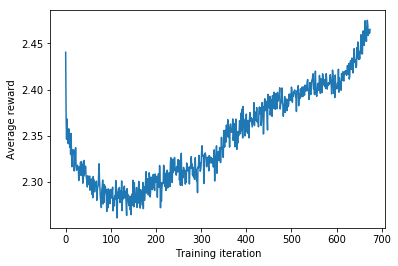

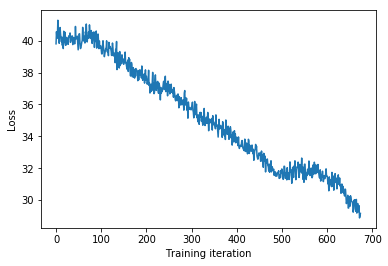

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 31.22it/s]


Mean value of predictions: 6.3205126755778664
Proportion of valid SMILES: 0.87


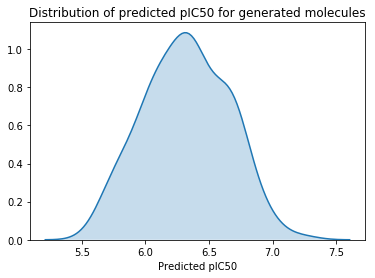

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCSCC(=O)O
CC(=NO)c1ccc(O)cc1
CC(=NOCC12CCCCC1C(CCC(C)C)C(=O)N2Cc1ccccc1)c1ccccc1
CC(=O)CC(=O)Nc1ccccc1
CC(=O)NCC(=O)N(C)Cc1ccccc1Cl


Policy gradient...: 100%|██████████| 15/15 [01:50<00:00,  7.43s/it]


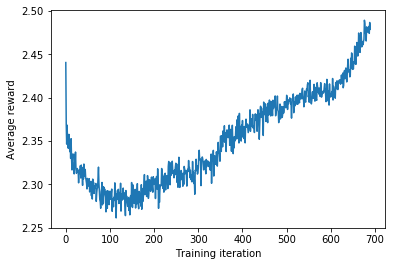

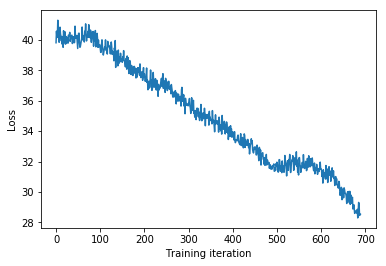

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Mean value of predictions: 6.277183764876989
Proportion of valid SMILES: 0.82


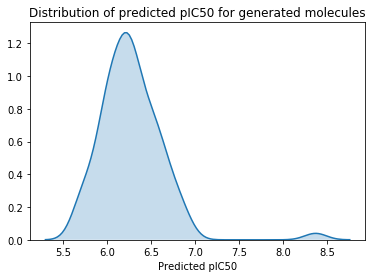

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Brc1ccccc1
C=C(C)C(=CCC1OC(C(C)O)C(C)(C)C(=O)C1O)NC(=O)C(C)=CC(=O)O
C=CCNC(=O)C12CCC(CCc3ccccc3)=C1C(=O)CC2(C)C
C=CCNC(=O)c1ccccc1
CC(=Cc1ccc2c(c1)N(C)C=CC(=O)N2Cc1ccccc1)NC(=O)OCc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:54<00:00,  7.50s/it]


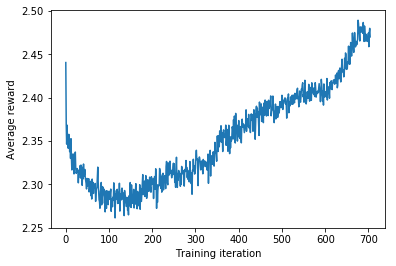

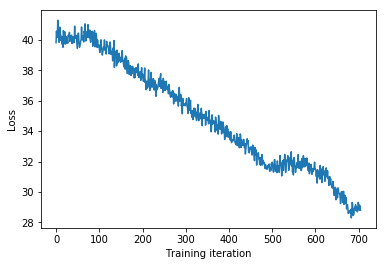

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 28.41it/s]


Mean value of predictions: 6.289489725165907
Proportion of valid SMILES: 0.865


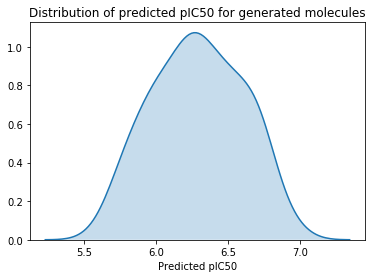

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(CC(=O)O)NCCC
C=CC1(C(F)(F)F)CCN(c2ccccn2)CC1
C=CCCCCNC(=O)C(O)C(=O)N(Cc1ccccc1)c1ccccc1OCC
CC(=Cc1ccccc1)NC(=O)c1ccccc1
CC(=NCCCC(CC(=O)O)c1ccccc1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:50<00:00,  7.27s/it]


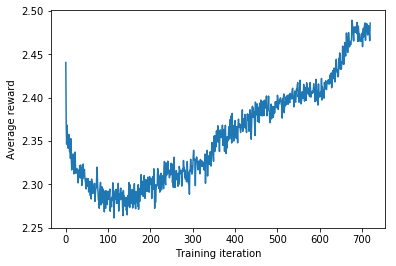

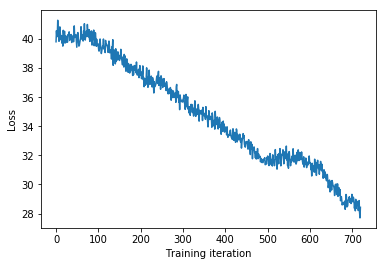

Generating molecules...: 100%|██████████| 200/200 [00:06<00:00, 30.59it/s]


Mean value of predictions: 6.2883145192001235
Proportion of valid SMILES: 0.87


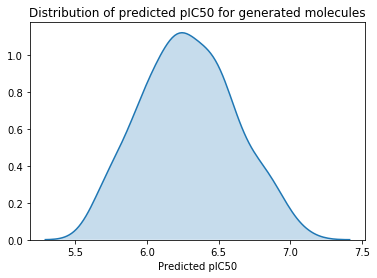

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Brc1ccccc1
C#CCCN1C(=O)C2CCN(CC)C2C1=O
C=CCN1C(=O)c2cc(-c3ccccc3)ccc2N=CN1C
C=CNN=Cc1ccco1
CC(=O)N1CCN1CCc1ccc(N(=O)=O)cc1


Policy gradient...: 100%|██████████| 15/15 [01:51<00:00,  7.59s/it]


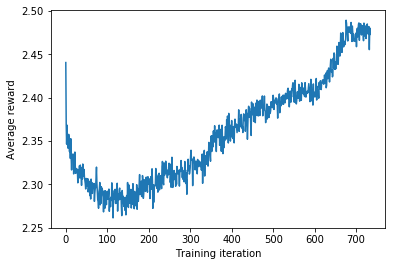

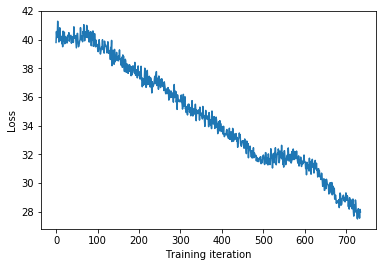

Generating molecules...:  81%|████████  | 162/200 [00:05<00:01, 29.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 40.58it/s]


Mean value of predictions: 6.147712154845446
Proportion of valid SMILES: 0.685


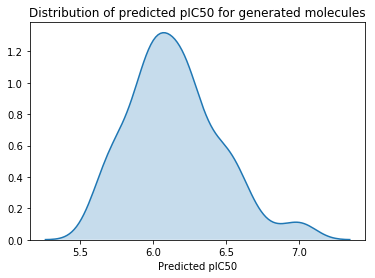

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCN(C(=O)c1ccc(OC)cc1)c1ccccc1
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=O)NC1CCC(CNc2ccccn2)CC1
CC(=O)Nc1ccc(-c2ccccc2)nc1
CC(=O)Nc1cccc(CNC(=O)Cc2ccccc2)c1


Policy gradient...: 100%|██████████| 15/15 [01:44<00:00,  6.90s/it]


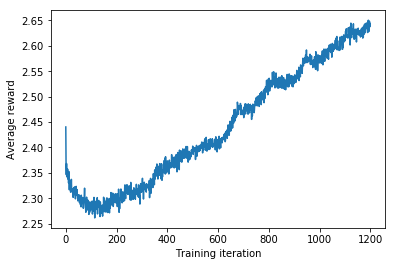

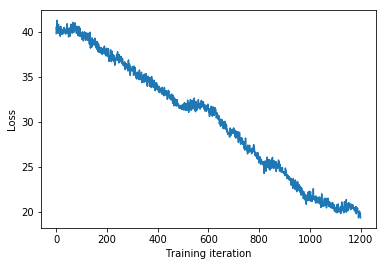

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 39.84it/s]


Mean value of predictions: 6.181487012251221
Proportion of valid SMILES: 0.695


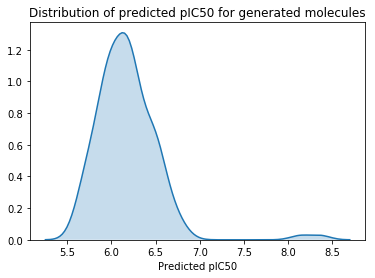

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C
C=CCSc1ccccc1
CC(=O)N1CCC2(C=CC2)C1
CC(=O)NC(=O)CCNC(=O)Cc1ccccc1
CC(=O)Nc1ccc(-c2ccccc2)cc1


Policy gradient...: 100%|██████████| 15/15 [01:43<00:00,  6.93s/it]


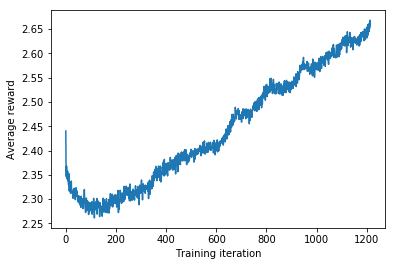

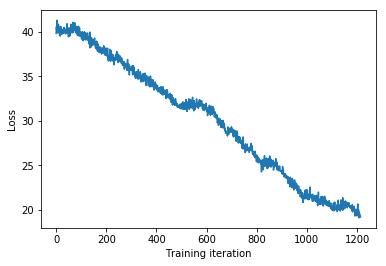

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 36.44it/s]


Mean value of predictions: 6.127155603053826
Proportion of valid SMILES: 0.72


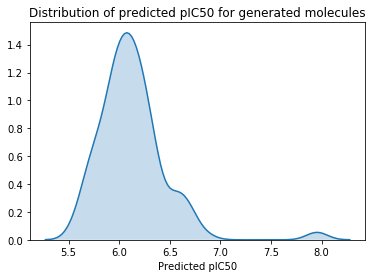

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(C)Cc1ccccc1
C=C(C)c1ccccc1
C=C(CC(=O)Nc1ccccc1)C(O)CC
C=CCSC1=NC(=O)NC(C)=C1C
CC(=NO)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:44<00:00,  6.96s/it]


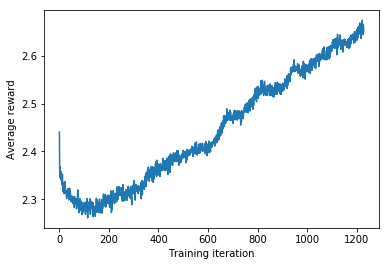

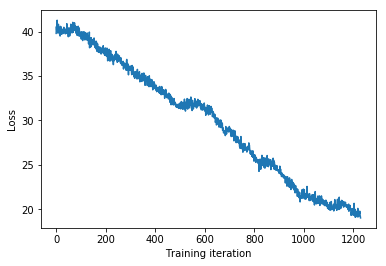

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 36.70it/s]


Mean value of predictions: 6.128532297358809
Proportion of valid SMILES: 0.71


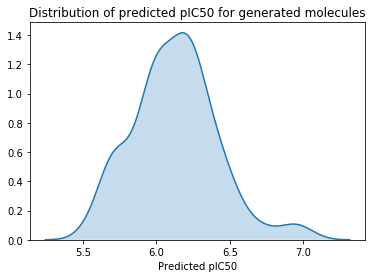

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(C(=O)Nc1cccc(Cl)c1)c1ccccc1C
C=CC(=O)Nc1ccccc1
C=CC(C)=CC=C(C)C=CC(=O)NCC=CC
C=CCN(C)CCCCc1ccccc1
CC(=O)N(c1ccccc1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:43<00:00,  6.92s/it]


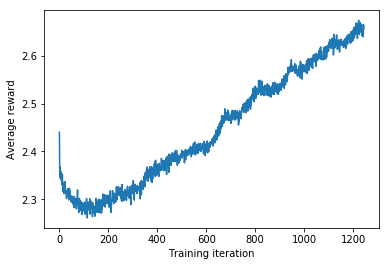

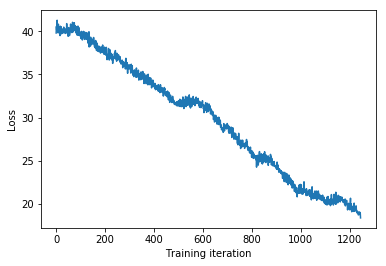

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 41.34it/s]


Mean value of predictions: 6.119887895905743
Proportion of valid SMILES: 0.64


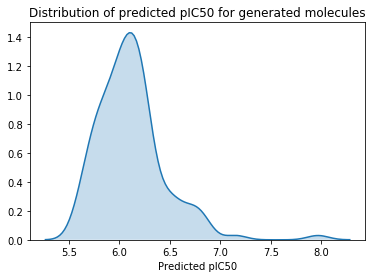

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCOc1ccccc1OC
CC(=O)NCc1ccccc1
CC(=O)NN=Cc1ccccc1
CC(=O)Nc1ccc(NC(=O)Nc2ccccc2)cc1
CC(=O)Nc1cccc(-n2cccc2)c1


Policy gradient...: 100%|██████████| 15/15 [01:42<00:00,  7.00s/it]


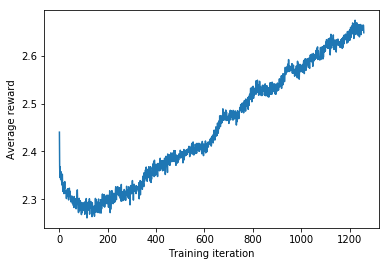

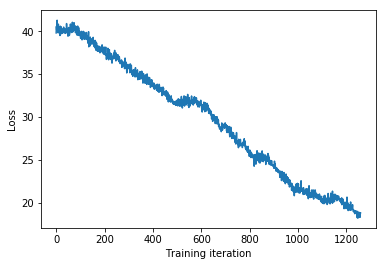

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 42.56it/s]


Mean value of predictions: 6.166126124204842
Proportion of valid SMILES: 0.685


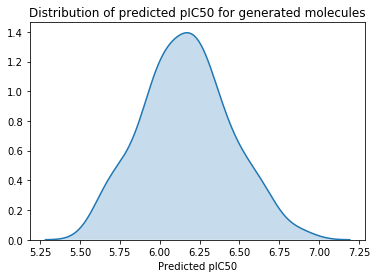

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(CC)C(=O)Nc1ccccn1
CC(=NNc1ccccc1)c1ccccc1
CC(=O)C(=Cc1ccccc1)c1ccccc1
CC(=O)Cc1ccccc1N
CC(=O)Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1


Policy gradient...: 100%|██████████| 15/15 [01:44<00:00,  6.89s/it]


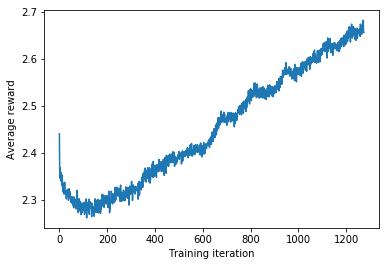

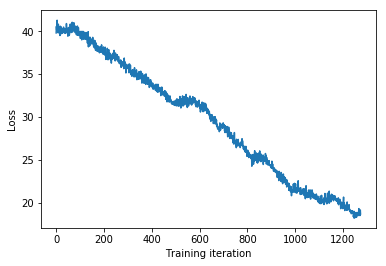

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 39.67it/s]


Mean value of predictions: 6.114915289551972
Proportion of valid SMILES: 0.705


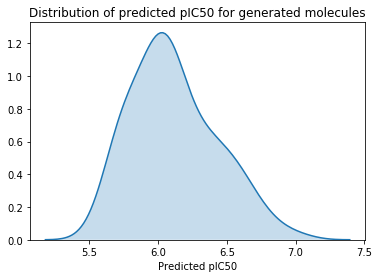

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=NNc1ccccc1)c1ccccc1
CC(=O)N(C)c1ccccc1
CC(=O)N(Cc1ccccc1)c1ccccc1
CC(=O)NC(=S)Nc1ccccc1
CC(=O)NC1=C(C=Cc2ccccc2)C(=O)Nc2ccccc21


Policy gradient...: 100%|██████████| 15/15 [01:44<00:00,  7.06s/it]


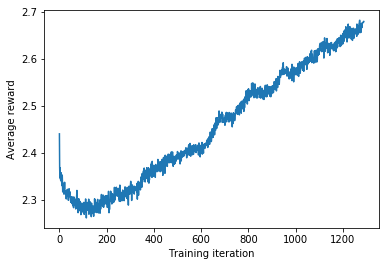

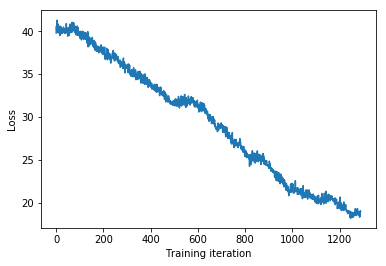

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 39.89it/s]


Mean value of predictions: 6.085758178480964
Proportion of valid SMILES: 0.685


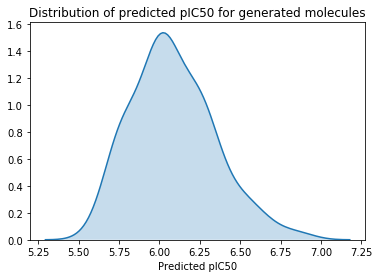

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C
C=CCN(CCCNC(=O)c1ccccc1)c1ccccc1
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=O)NCCOc1ccccc1
CC(=O)Nc1ccc(C(=O)Nc2ccccc2)cc1


Policy gradient...: 100%|██████████| 15/15 [01:44<00:00,  6.96s/it]


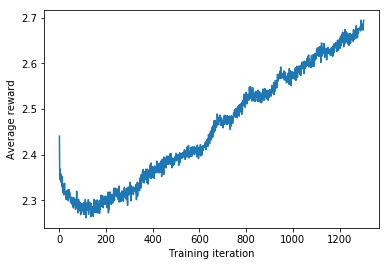

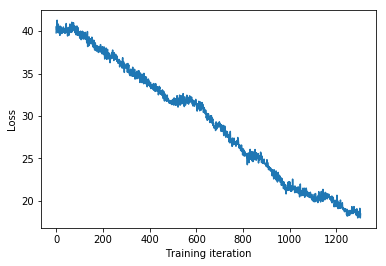

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 39.19it/s]


Mean value of predictions: 6.131828867772803
Proportion of valid SMILES: 0.74


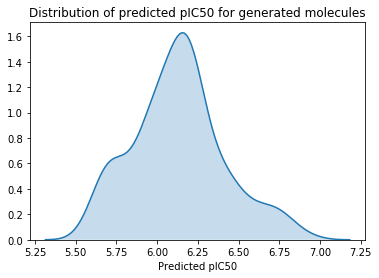

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CC(=O)Nc1ccccc1
C=CCN(CC(N)=O)c1ccccc1
CC(=NSc1ccccc1)c1ccccc1
CC(=O)CCc1ccccc1
CC(=O)N(C)CNc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:43<00:00,  6.89s/it]


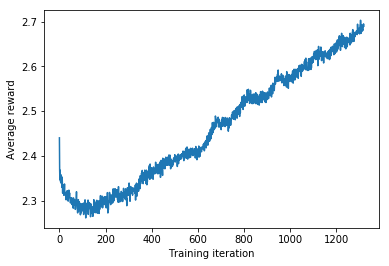

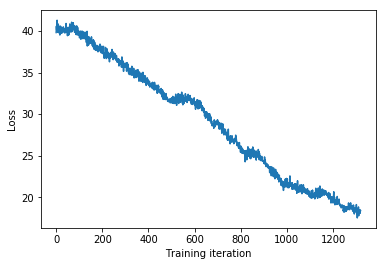

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 38.51it/s]


Mean value of predictions: 6.114444274846087
Proportion of valid SMILES: 0.72


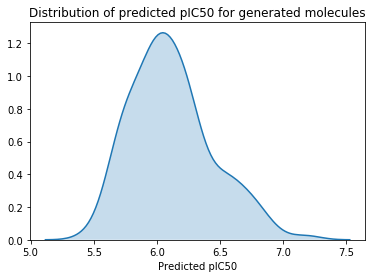

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(c1ccccc1)c1ccccc1C
C=CC(=O)Nc1ccccc1
CC(=Cc1ccc(Oc2ccccc2)cc1)c1ccccc1
CC(=NNC(N)=O)c1ccccc1
CC(=NNc1cccc(Cl)c1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:43<00:00,  7.00s/it]


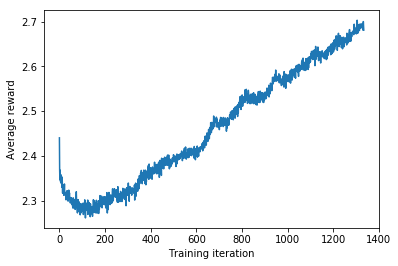

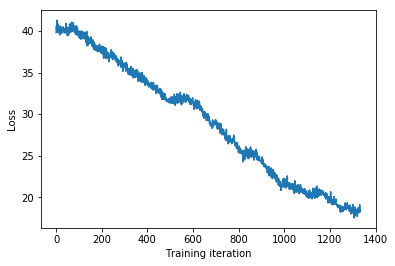

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 41.27it/s]


Mean value of predictions: 6.115163758501215
Proportion of valid SMILES: 0.69


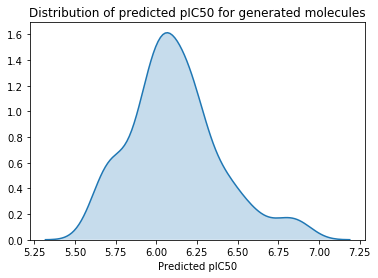

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=Cc1ccccc1)c1ccccc1
CC(=NNc1ccccc1)c1ccccc1
CC(=O)NC1CCc2ccccc21
CC(=O)NCC(=O)Nc1ccccc1
CC(=O)Nc1ccc(C(=O)Nc2ccccc2)cc1


Policy gradient...: 100%|██████████| 15/15 [01:42<00:00,  6.76s/it]


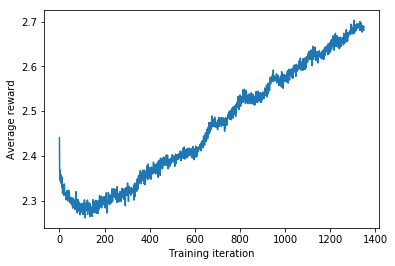

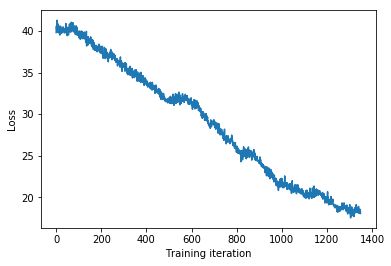

Generating molecules...:  100%|█████████| 200/200 [00:03<00:01, 44.31it/s]


In [45]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_min.policy_gradient(gen_data, get_features=get_fp)
        rewards_min.append(simple_moving_average(rewards_min, cur_reward)) 
        rl_losses_min.append(simple_moving_average(rl_losses_min, cur_loss))
    
    plt.plot(rewards_min)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_min)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_min.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Generating molecules...: 100%|██████████| 10000/10000 [03:37<00:00, 44.75it/s]


Mean value of predictions: 6.179443750551513
Proportion of valid SMILES: 0.2475


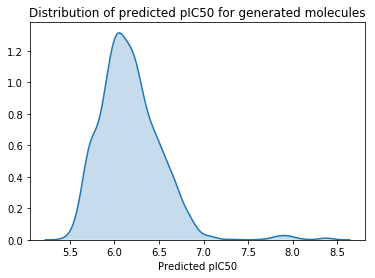

In [46]:
smiles_biased_min, prediction_biased_min = estimate_and_update(RL_min.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

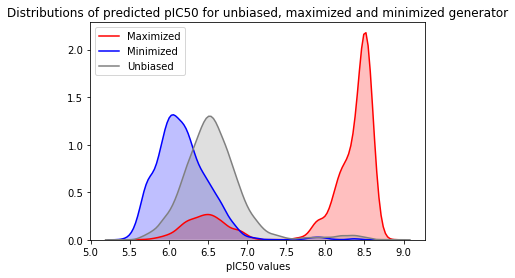

In [51]:
sns.kdeplot(prediction_biased_max, label='Maximized', shade=True, color='red')
sns.kdeplot(prediction_biased_min, label='Minimized', shade=True, color='blue')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('pIC50 values')
plt.title('Distributions of predicted pIC50 for unbiased,' + 
          ' maximized and minimized generator')
plt.show()

## Drawing random molecules

Now we will draw some random compounds from the biased library:

In [38]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

### Molecules with maximized pIC50

In [67]:
generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_max]
sanitized_gen_mols_max = [generated_mols_max[i] 
                          for i in np.where(np.array(generated_mols_max) != None)[0]]

In [68]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols_max), n_to_draw)
mols_to_draw_max = [sanitized_gen_mols_max[i] for i in ind]
legends = ['pIC50 = ' + str(prediction_biased_max[i]) for i in ind]

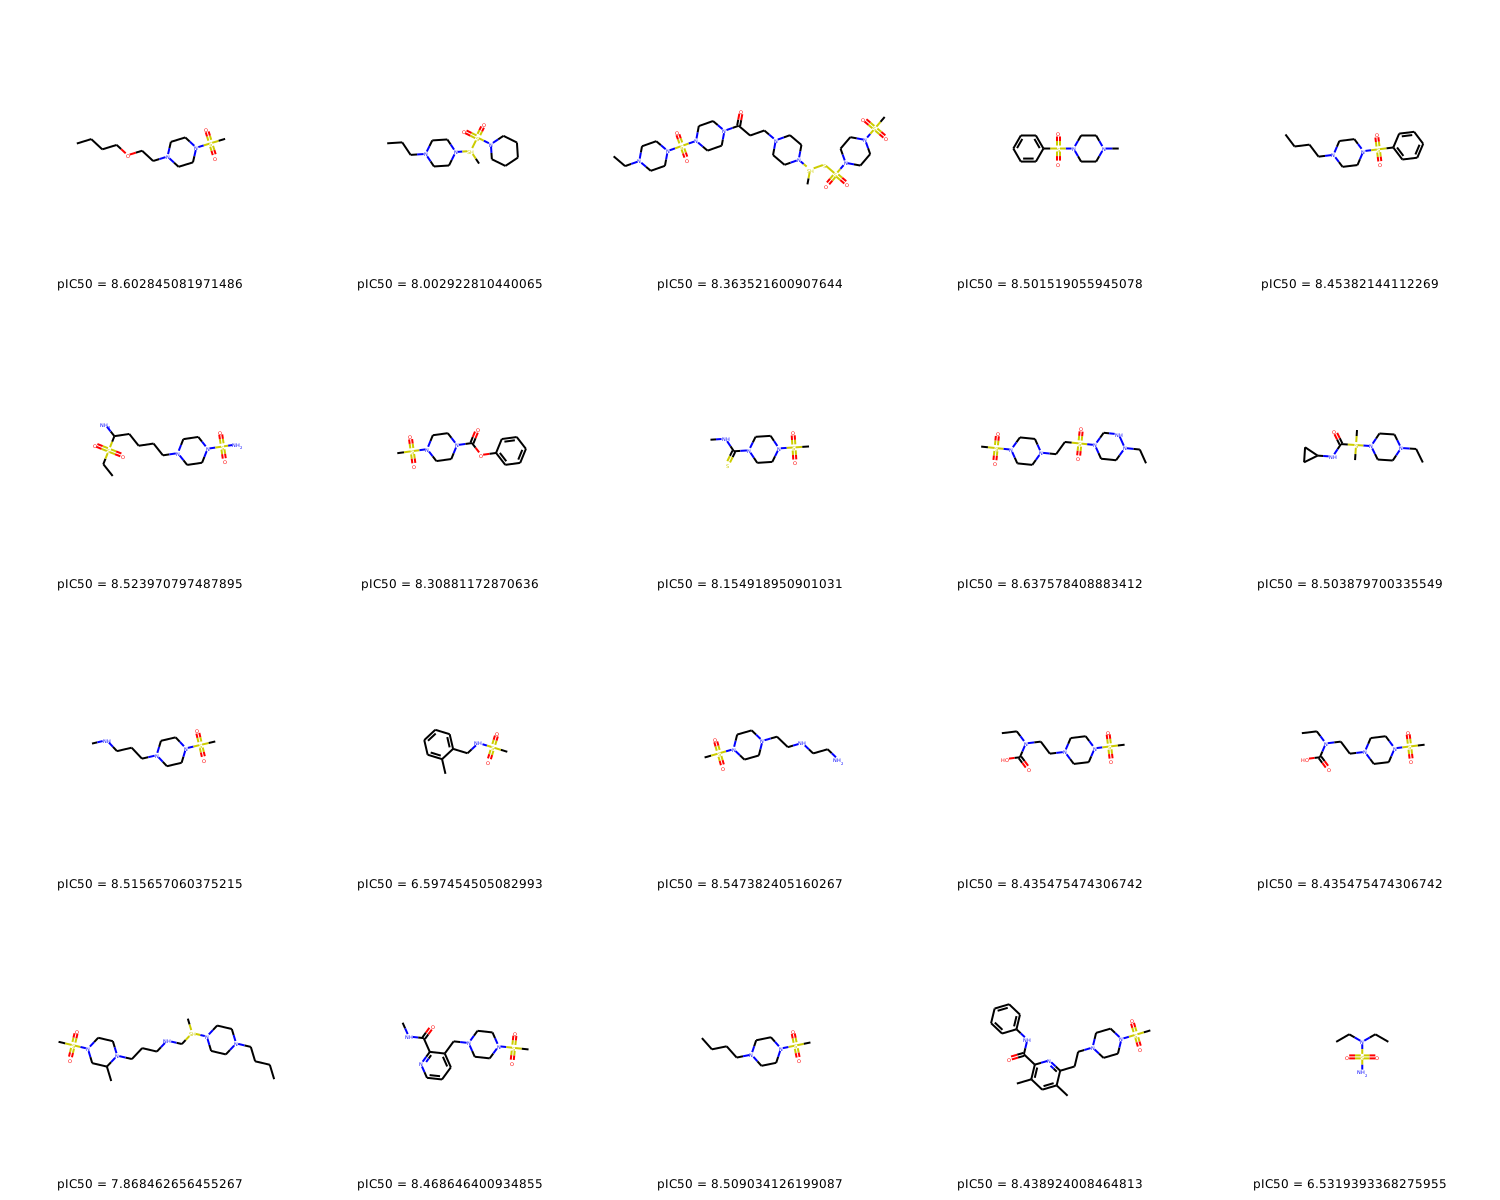

In [71]:
Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

### Molecules with minimized pIC50

In [72]:
generated_mols_min = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_min]
sanitized_gen_mols_min = [generated_mols_min[i] 
                          for i in np.where(np.array(generated_mols_min) != None)[0]]

In [73]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols_min), n_to_draw)
mols_to_draw_min = [sanitized_gen_mols_min[i] for i in ind]
legends = ['pIC50 = ' + str(prediction_biased_min[i]) for i in ind]

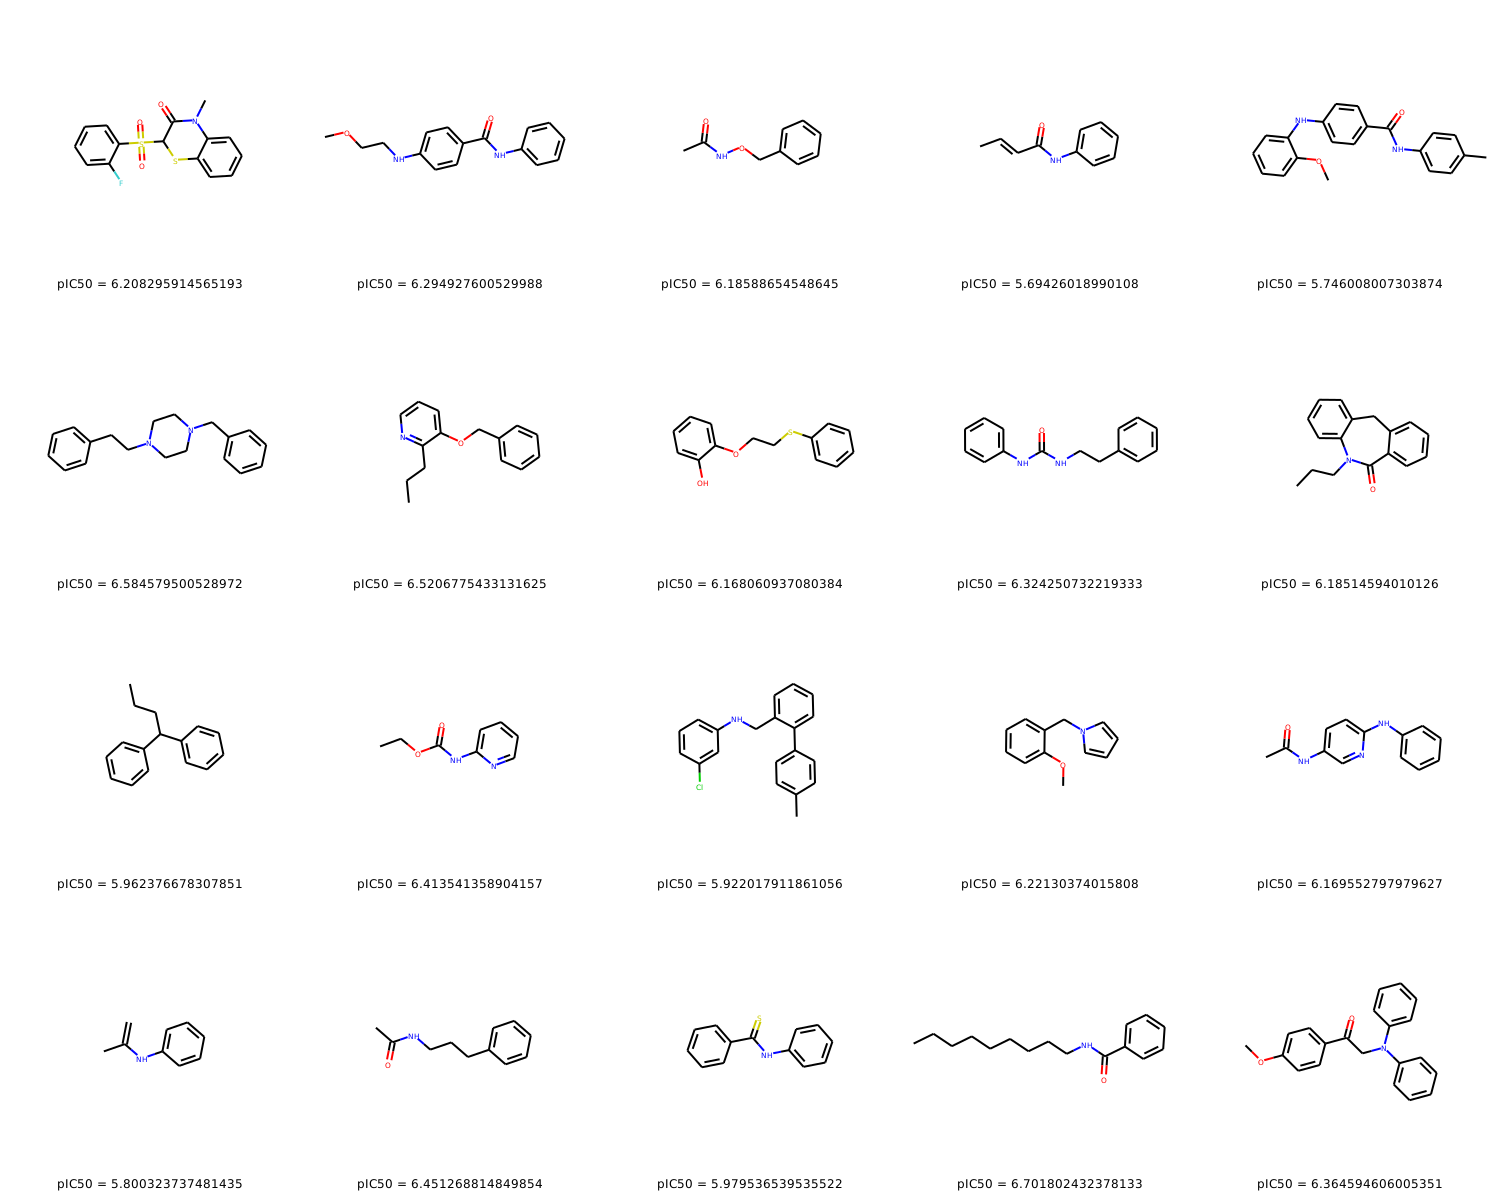

In [74]:
Draw.MolsToGridImage(mols_to_draw_min, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)